In [3]:
import os

import numpy as np

import pandas as pd
import geopandas as gpd
from shapely import Point
from shapely.geometry import LineString
from scipy.spatial.distance import directed_hausdorff

from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import dask

In [4]:
gdf = gpd.read_file("labeled_trajectories-all.geoJSON")
zones = gpd.read_file("C:/Users/anape/Downloads/outsight/resources/QGIS/lanes_and_int.geojson")

In [5]:
def dh_linestring(line1,line2):
    line1 = list(zip(*line1.xy))
    line2 = list(zip(*line2.xy))
    distance = directed_hausdorff(line1, line2)
    return distance[0]

In [6]:
gdf.shape

(2223, 3)

In [7]:
def dh_linestring(line1,line2):
    line1 = list(zip(*line1.xy))
    line2 = list(zip(*line2.xy))
    distance = directed_hausdorff(line1, line2)
    return distance[0]

n = gdf.shape[0]
trajectories = list(gdf['geometry'])
D = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        dist = dh_linestring(trajectories[i],trajectories[j])
        D[i][j] = dist

In [ ]:
import dask
from dask import delayed
import dask.array as da
from shapely.geometry import LineString
from scipy.spatial.distance import directed_hausdorff
import numpy as np

# Define a delayed function to compute directed Hausdorff distance
@delayed
def dh_linestring(line1, line2):
    line1 = list(zip(*line1.xy))
    line2 = list(zip(*line2.xy))
    distance = directed_hausdorff(line1, line2)
    return distance[0]

# Assuming gdf is a GeoDataFrame with 'geometry' column
n = gdf.shape[0]
trajectories = list(gdf['geometry'])

# Construct delayed computations for distance matrix
delayed_computations = []
for i in range(n):
    for j in range(n):
        dist = dh_linestring(trajectories[i], trajectories[j])
        delayed_computations.append(dist)



In [34]:
# Compute the delayed computations
results = dask.compute(delayed_computations)
listoflists = list(zip(*[iter(results[0])] * 2234))

# D is now the directed Hausdorff distance matrix
D=np.array([np.array(xi) for xi in listoflists])

# saving as a file in order to avoid recalculations, which take 3h+
import csv
with open("out.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(D)

In [157]:
D =  np.genfromtxt('out.csv', delimiter=',')

In [ ]:
eps_values = np.arange(100, 210, 10)  # 10 values between 100 and 200
min_pts = np.arange(5, 16)  # 10 values between 5 and 15

# Create a 2D array to store the cluster numbers
cluster_numbers = np.zeros((len(eps_values), len(min_pts)), dtype=int)
noise = np.zeros((len(eps_values), len(min_pts)), dtype=int)


for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_pts):
        mdl = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_lst = mdl.fit_predict(D)
        num_clusters = len(set(cluster_lst)) 
        cluster_numbers[i, j] = num_clusters
        noise[i, j] = np.sum(cluster_lst == -1)

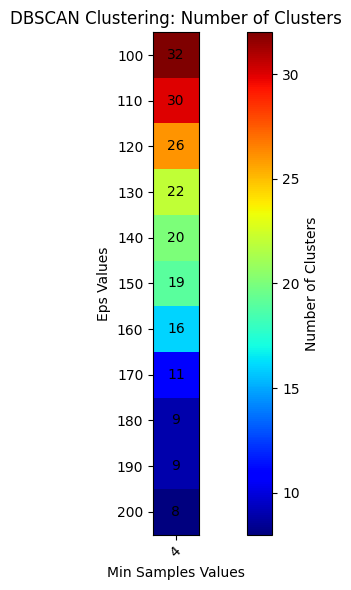

In [ ]:
y_ticks = eps_values
x_ticks = min_pts

# Create a heatmap of cluster numbers
plt.figure(figsize=(10, 6))
plt.imshow(cluster_numbers,cmap=plt.cm.jet)
plt.colorbar(label='Number of Clusters')
plt.ylabel('Eps Values')
plt.xlabel('Min Samples Values')
plt.xticks(np.arange(len(x_ticks)), x_ticks, rotation=45)
plt.yticks(np.arange(len(y_ticks)), y_ticks)
plt.title('DBSCAN Clustering: Number of Clusters')

for i in range(len(y_ticks)):
    for j in range(len(x_ticks)):
        plt.text(j, i, str(cluster_numbers[i, j]), ha='center', va='center', color='black')

plt.grid(False)
plt.tight_layout()
plt.show()

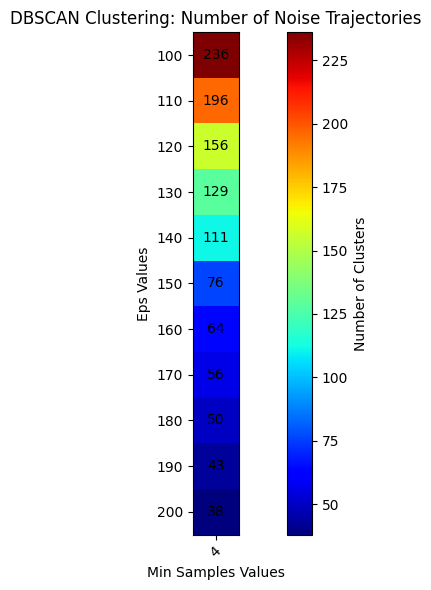

In [ ]:
y_ticks = eps_values
x_ticks = min_pts

# Create a heatmap of cluster numbers
plt.figure(figsize=(10, 6))
plt.imshow(noise,cmap=plt.cm.jet)
plt.colorbar(label='Number of Clusters')
plt.ylabel('Eps Values')
plt.xlabel('Min Samples Values')
plt.xticks(np.arange(len(x_ticks)), x_ticks, rotation=45)
plt.yticks(np.arange(len(y_ticks)), y_ticks)
plt.title('DBSCAN Clustering: Number of Noise Trajectories')

for i in range(len(y_ticks)):
    for j in range(len(x_ticks)):
        plt.text(j, i, str(noise[i, j]), ha='center', va='center', color='black')

#plt.grid(False)
plt.tight_layout()
plt.show()

12


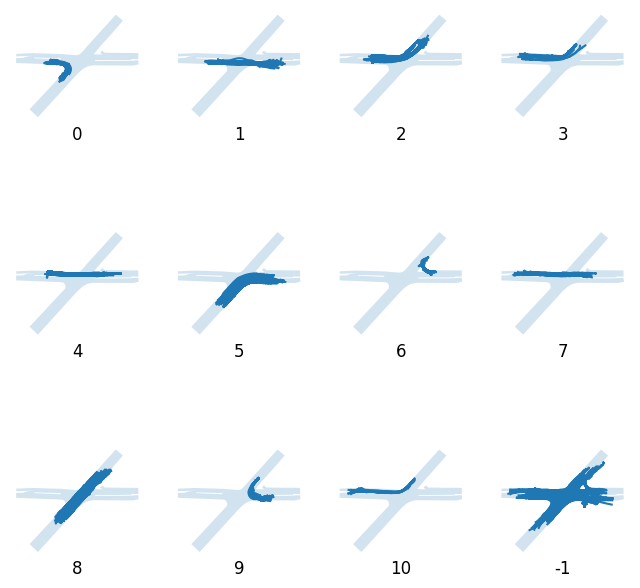

In [ ]:
eps = 150
samples = 9
mdl = DBSCAN(eps=eps,min_samples=samples)
cluster_lst = mdl.fit_predict(D)
print(len(set(cluster_lst)))


gdf['dbscan'] = cluster_lst

fig, axes = plt.subplots(3,4,figsize=(8,8))
for i, group in gdf.groupby('dbscan'):
    ax=axes.flatten()[i]
    zones.plot(alpha=.2,ax=ax)
    group.plot(ax=ax)
    ax.axis('off')
    ax.text(0.5, -0.15, f'{i}', fontsize=12, color='black', ha='center', transform=ax.transAxes)



In [ ]:
gdf[gdf['dbscan']==-1].shape

(184, 5)

(289, 4)

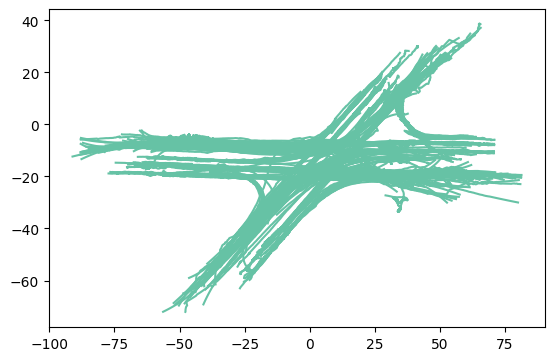

In [ ]:
gdf[gdf['dbscan'] == -1].plot(column='dbscan',cmap='Set2')
gdf[gdf['dbscan'] == -1].shape